# Official realization of the proposed metod

#### August 2024

### Import libraries

In [1]:
from pandas import json_normalize
import pandas as pd
import numpy as np
import copy
import shap
import joblib
import json
from tqdm import tqdm

from sdmetrics.column_pairs import CorrelationSimilarity, ContingencySimilarity
from sdmetrics.single_table import NewRowSynthesis
from sdmetrics.single_column import MissingValueSimilarity, TVComplement
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CopulaGANSynthesizer, TVAESynthesizer, CTGANSynthesizer
from rdt.transformers.numerical import GaussianNormalizer
import scipy.stats as sts
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from synthetic_data_generation import generate_synth_C, generate_synth_R
from evaluation import *
from prediction import *
from modified_WGAN import *

In [3]:
import matplotlib as mpl
#set params for the article
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.labelsize'] = 18

#set params for the notebook
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
# mpl.rcParams['legend.fontsize'] = 10
# mpl.rcParams['axes.labelsize'] = 14

### Import data

In [4]:
data_clf = pd.read_csv('Data/input60NY (C).csv').drop(30)
data_reg = pd.read_csv('Data/input60NY.csv').drop(30)

data_big_reg = pd.read_csv('Data/citiesdataset-NYDcor-4.csv')
data_big_clf = pd.read_csv('Data/citiesdataset-NYDcor-4 (CLASS).csv')

In [5]:
data_clf = data_clf.drop('avgemployers', axis=1)
data_reg = data_reg.drop('avgemployers', axis=1)
data_big_reg = data_big_reg.drop('avgemployers', axis=1)
data_big_clf = data_big_clf.drop('avgemployers', axis=1)

In [6]:
# temp = data_reg.sample(frac=1)
# data_reg = temp.iloc[:-10]
# data_reg_test = temp.iloc[-10:]

In [7]:
# data_clf_test = data_clf.loc[data_reg_test.index]
# data_clf = data_clf.loc[data_reg.index]

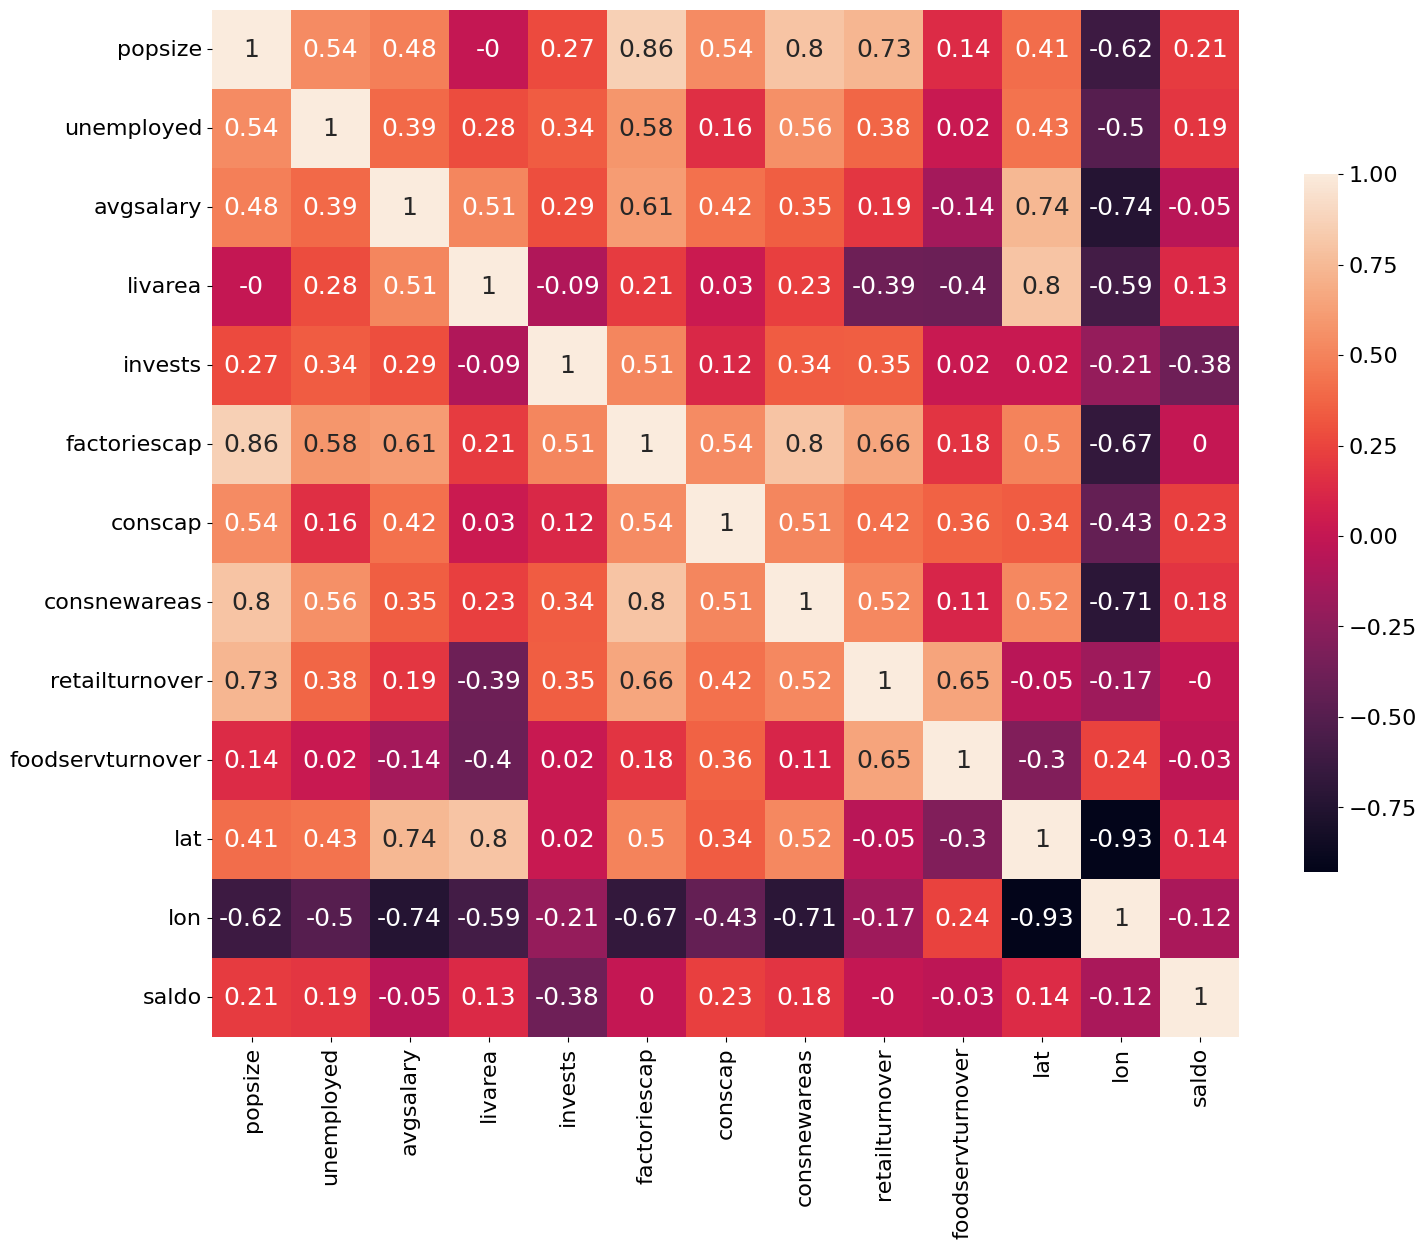

In [8]:
plot_corr(data_reg[data_reg.columns], 'images/corr_small.pdf', save=False)

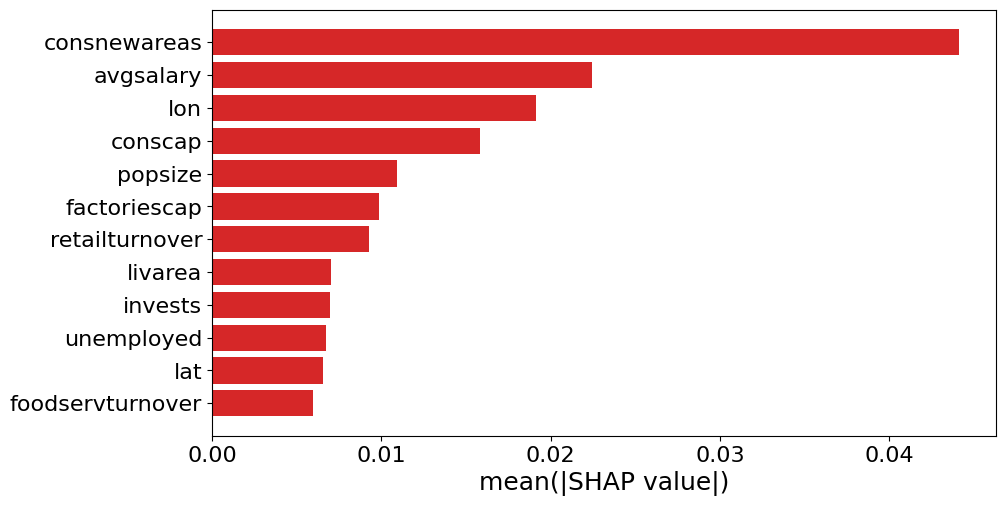

In [9]:
feature_importance(X=data_big_reg[data_reg.columns].drop('saldo', axis=1), y=data_big_reg[data_reg.columns]['saldo'],
                   path='images/feat_import_big.pdf', save=False)

### Train generator for classification task

In [10]:
synth_data_clf, synth_metrics_mean_clf = generate_synth_C(data_clf, TVAESynthesizer, n_samples=5000)

In [11]:
synth_metrics_mean_clf

{'corr_sim': 0.9544682755287367, 'TV': 0.9400000000000002, 'new_row': 0.996}

In [12]:
c2st(data_clf, synth_data_clf)

(0.506, 0.4742374928096673)

In [13]:
# Uncomment the code below to draw histograms

# plot_hist(data_clf, synth_data_clf)

### Train generator for regression task

In [14]:
synth_data_reg, synth_metrics_mean_reg = generate_synth_R(data_reg, TVAESynthesizer, n_samples=5000)

In [15]:
synth_metrics_mean_reg

{'corr_sim': 0.9552856320174591, 'new_row': 0.9984999999999999}

In [16]:
c2st(data_reg, synth_data_reg.sample(len(data_reg)))

(0.4487931034482757, 0.709359709453346)

In [81]:
# Uncomment the code below to draw histograms

# plot_hist(data_reg, synth_data_reg)

In [22]:
# synth_data_clf.to_csv('Data/synth_data_clf.csv', index=False, header=True)
# synth_data_reg.to_csv('Data/synth_data_reg.csv', index=False, header=True)

## Import presave synthetic data

In [12]:
# synth_data_reg = pd.read_csv('Data/synth_data_reg.csv')
# synth_data_clf = pd.read_csv('Data/synth_data_clf.csv')

In [17]:
synth_data_clf_sam = pd.DataFrame(np.zeros(data_clf.shape), columns=data_clf.columns)

for _ in range(31):
    synth_data_clf_sam = synth_data_clf_sam + synth_data_clf.sample(len(data_clf)).reset_index(drop=True)
    
synth_data_clf_sam = synth_data_clf_sam / 31

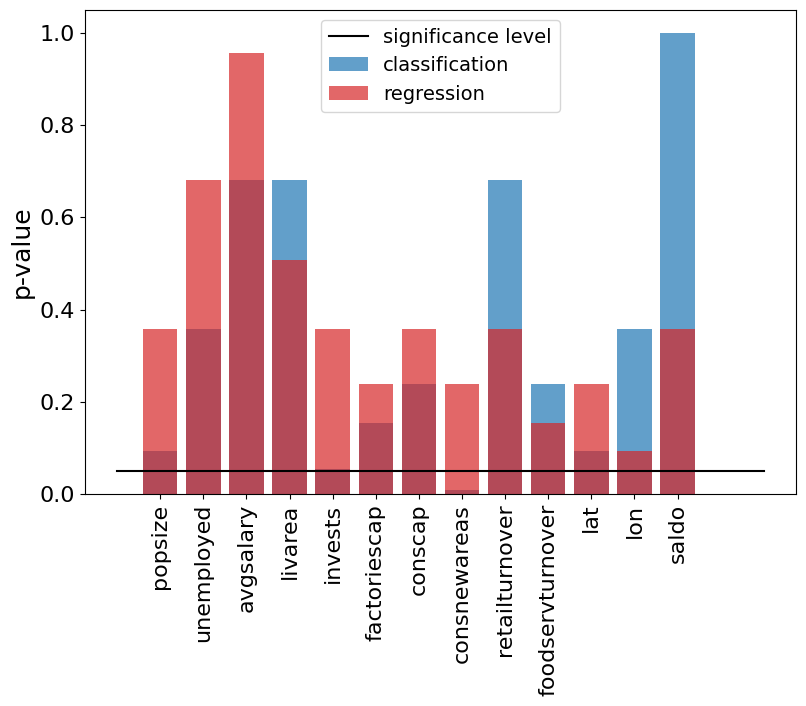

In [18]:
plot_significance_ks(data_clf, synth_data_clf, data_reg, synth_data_reg, path='images/pvalue_CopulaGAN.pdf', save=False)

## Statistically significant experiments

In [19]:
synth_data_clf = copy.deepcopy(synth_data_reg)
synth_data_clf['saldo'] = synth_data_reg['saldo'].apply(lambda x: 0 if x<0 else 1)

In [23]:
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVC, SVR


# reg_model = XGBRegressor(n_estimators=100, max_depth=3)
# clf_model = XGBClassifier(n_estimators=100, max_depth=3)

reg_model = RandomForestRegressor(n_estimators=100)
clf_model = RandomForestClassifier(n_estimators=100)

# reg_model = LinearRegression()
# clf_model = XGBClassifier(n_estimators=100)

# reg_model = MLPRegressor(solver='adam', alpha=3e-4, max_iter=2000, hidden_layer_sizes=(64, 128, 64,), activation='relu')
# clf_model = MLPClassifier(solver='adam', alpha=3e-4, max_iter=2000, hidden_layer_sizes=(64, 128, 64,), activation='relu')


# reg_model = SVR()
# clf_model = SVC()


errors = train_models(data_reg, data_clf, data_big_reg, synth_data_reg, synth_data_clf, reg_model, clf_model)

100%|██████████| 100/100 [12:36<00:00,  7.56s/it]


In [25]:
z_critical = sts.norm.ppf(q = 1 - 0.05/2)

pd.DataFrame([
              [f'{round(np.mean(errors["MAE_small"]), 3)} +- {round(np.std(errors["MAE_small"], ddof=1), 3)}',
               f'{np.around(np.mean(errors["MAE_small"]),3)} +- {np.around(z_critical * (np.std(errors["MAE_small"],ddof=1) / np.sqrt(len(errors["MAE_small"]))),3)}',
               f'{round(np.mean(errors["MSE_small"]), 3)} +- {round(np.std(errors["MSE_small"], ddof=1), 3)}'],
              
              [f'{round(np.mean(errors["MAE_synth_reg"]), 3)} +- {round(np.std(errors["MAE_synth_reg"], ddof=1), 3)}',
               f'{np.around(np.mean(errors["MAE_synth_reg"]),3)} +- {np.around(z_critical * (np.std(errors["MAE_synth_reg"],ddof=1) / np.sqrt(len(errors["MAE_synth_reg"]))),3)}',
               f'{round(np.mean(errors["MSE_synth_reg"]), 3)} +- {round(np.std(errors["MSE_synth_reg"], ddof=1), 3)}'],
              
              [f'{round(np.mean(errors["MAE_big"]), 3)} +- {round(np.std(errors["MAE_big"], ddof=1), 3)}',
               f'{np.around(np.mean(errors["MAE_big"]),3)} +- {np.around(z_critical * (np.std(errors["MAE_big"],ddof=1) / np.sqrt(len(errors["MAE_big"]))),3)}',
               f'{round(np.mean(errors["MSE_big"]), 3)} +- {round(np.std(errors["MSE_big"], ddof=1), 3)}'],
              
              [f'{round(np.mean(errors["MAE_adjusted"]), 3)} +- {round(np.std(errors["MAE_adjusted"], ddof=1), 3)}',
               f'{np.around(np.mean(errors["MAE_adjusted"]),3)} +- {np.around(z_critical * (np.std(errors["MAE_adjusted"],ddof=1) / np.sqrt(len(errors["MAE_adjusted"]))),3)}',
               f'{round(np.mean(errors["MSE_adjusted"]), 3)} +- {round(np.std(errors["MSE_adjusted"], ddof=1), 3)}']
            
              ], index=['Real small cities', 'Synth regression', 'Real big cities', 'Synth reg + synth clf'], columns=['Mean MAE +- STD', 'CI MAE, 95%', 'Mean MSE +- STD'])

,Mean MAE +- STD,"CI MAE, 95%",Mean MSE +- STD
Real small cities,308.033 +- 95.174,308.033 +- 18.654,2.893 +- 1.694
Synth regression,103.501 +- 4.765,103.501 +- 0.934,0.355 +- 0.048
Real big cities,580.851 +- 53.664,580.851 +- 10.518,7.502 +- 1.094
Synth reg + synth clf,103.637 +- 5.368,103.637 +- 1.052,0.366 +- 0.049


## Step by step with cross validation

### Train classifier

In [80]:
# model_clf, errors_clf = classification(data_big_clf, data_clf, n_trials=30, test_size=0.2)
# model_clf, errors_clf = classification(data_clf, data_clf, n_trials=30, test_size=0.2)
model_clf, errors_clf = classification(synth_data_clf, data_clf, n_trials=30, test_size=0.2)

[I 2024-08-20 14:12:04,946] A new study created in memory with name: no-name-8ec383a7-5053-4956-9871-0b5f4a8c01ab
[I 2024-08-20 14:12:06,961] Trial 0 finished with value: 0.9046486524887394 and parameters: {'n_estimators': 150, 'max_depth': 3}. Best is trial 0 with value: 0.9046486524887394.
[I 2024-08-20 14:12:07,710] Trial 1 finished with value: 0.8532037737969222 and parameters: {'n_estimators': 150, 'max_depth': 1}. Best is trial 0 with value: 0.9046486524887394.
[I 2024-08-20 14:12:10,245] Trial 2 finished with value: 0.9091029428919544 and parameters: {'n_estimators': 150, 'max_depth': 4}. Best is trial 2 with value: 0.9091029428919544.
[I 2024-08-20 14:12:10,944] Trial 3 finished with value: 0.8532037737969222 and parameters: {'n_estimators': 150, 'max_depth': 1}. Best is trial 2 with value: 0.9091029428919544.
[I 2024-08-20 14:12:12,353] Trial 4 finished with value: 0.8592707287928267 and parameters: {'n_estimators': 300, 'max_depth': 1}. Best is trial 2 with value: 0.909102942

### Presave model

In [70]:
# joblib.dump(model_clf, "model_clf.pkl") 
# np.save('errors_clf.npy', errors_clf) 

In [71]:
# model_clf = joblib.load("model_clf.pkl")
# errors_clf = np.load('errors_clf.npy', allow_pickle='TRUE').item()

In [81]:
errors_clf

{'F1 train': 0.9972801450589301,
 'F1 val': 0.8995260663507109,
 'F1 real test': 0.95,
 'F1 CV': 0.8743621647345228,
 'roc_auc_score': 0.9449153775647469}

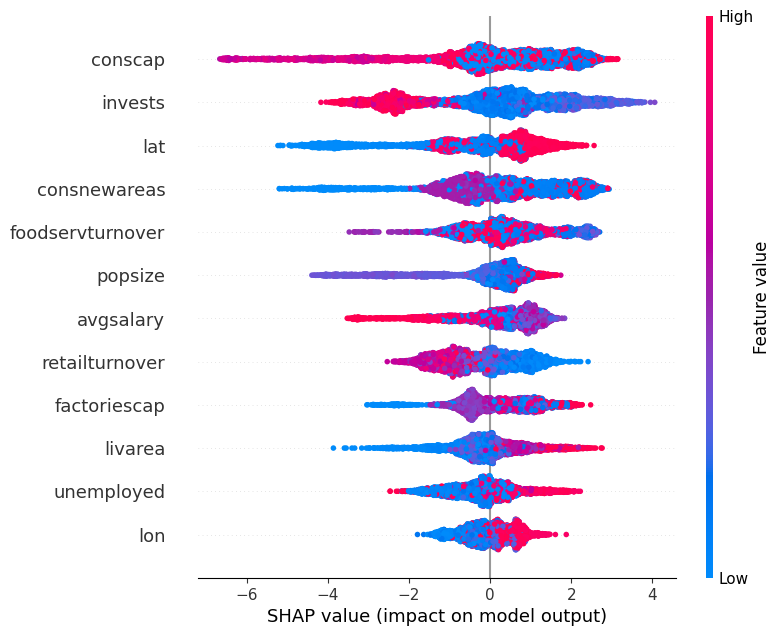

In [29]:
plot_shap(model_clf, data_clf, synth_data_clf, path='images/feature_importance.pdf', save=False)

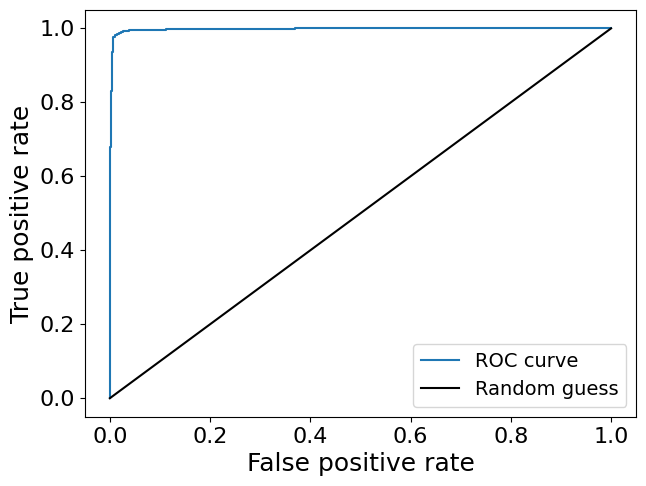

In [31]:
plot_roc_curve(model_clf, synth_data_clf, path='images/roc_curve.pdf', save=False)

### Enhance regression syntehtic (OPTIONAL)

In [34]:
# reg_NN, reg_losses = train_reg_NN(synth_data_reg, batch_size=64, epochs=2000)
# synth_data_reg_enh, losses = train_modified_WGAN(synth_data_reg, reg_NN, epochs=2000)

In [35]:
# plot_losses(losses)

In [36]:
# plot_hist_kde(synth_data_reg_enh, synth_data_reg)

### Train regressor

In [93]:
# model_reg, errors_reg = regression(synth_data_reg_enh, data_reg, n_trials=30, test_size=0.2) #enhanced synth small cities
# model_reg, errors_reg = regression(data_big_reg, data_reg, n_trials=30, test_size=0.2) #big cities
# model_reg, errors_reg = regression(data_reg, data_reg, n_trials=30, test_size=0.2) #small cities
model_reg, errors_reg = regression(synth_data_reg, data_reg, n_trials=30, test_size=0.2) #synth small cities

[I 2024-08-20 14:16:55,042] A new study created in memory with name: no-name-8f274953-21cc-435b-bae9-9e162f1dcc3e
[I 2024-08-20 14:16:58,310] Trial 0 finished with value: -2.8787539208145226e-05 and parameters: {'n_estimators': 200, 'max_depth': 4}. Best is trial 0 with value: -2.8787539208145226e-05.
[I 2024-08-20 14:17:00,004] Trial 1 finished with value: -3.6972979473870376e-05 and parameters: {'n_estimators': 200, 'max_depth': 2}. Best is trial 1 with value: -3.6972979473870376e-05.
[I 2024-08-20 14:17:03,314] Trial 2 finished with value: -2.8787539208145226e-05 and parameters: {'n_estimators': 200, 'max_depth': 4}. Best is trial 1 with value: -3.6972979473870376e-05.
[I 2024-08-20 14:17:05,484] Trial 3 finished with value: -3.585139871265857e-05 and parameters: {'n_estimators': 250, 'max_depth': 2}. Best is trial 1 with value: -3.6972979473870376e-05.
[I 2024-08-20 14:17:06,735] Trial 4 finished with value: -3.424132204702899e-05 and parameters: {'n_estimators': 100, 'max_depth': 

## Presave model

In [94]:
# joblib.dump(model_reg, "model_reg.pkl") 
# np.save('errors_reg.npy', errors_reg) 

In [95]:
# model_reg = joblib.load("model_reg.pkl")
# errors_reg = np.load('errors_reg.npy', allow_pickle='TRUE').item()

In [97]:
errors_reg

{'MAPE train': 2.4661274499808896,
 'MAPE val': 3.359094686875749,
 'MAPE real test': 1.298280983603222,
 'MAE CV': 127.8305595258881,
 'MSE x 10e-4': 0.7115392695630262}

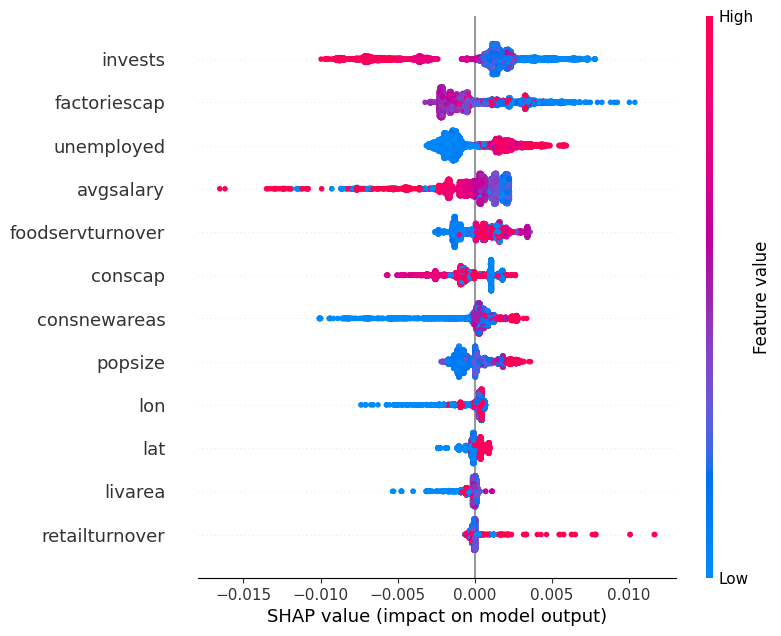

In [36]:
plot_shap(model_reg, data_reg, synth_data_reg, path='images/feature_importance_reg.pdf', save=False)

### Correct prediction

In [98]:
prediction = correct_prediction(model_clf, model_reg, data_reg)

### Quantitative Evaluation

Ошибка MSE в $10^{-4}$

In [99]:
mean_squared_error(data_reg['saldo'], prediction) * 10000

1.3020401771747185

Ошибка MAE в людях

In [100]:
mean_absolute_error(data_reg['saldo'], prediction) * 26466

167.65733426968322

Ошибка MAPE в людях

In [101]:
mean_absolute_percentage_error(data_reg['saldo']*26466, prediction*26466)

1.167022289791848

In [ ]:
plot_qq_with_axis(data_reg, prediction, save=False)